# Downstream Analyses of Factor Loadings

Here we use the loadings obtained with Tensor-cell2cell for each element in their respective dimensions (contexts, ligand-receptor pairs, sender cells, receiver cells). These loadings represent the importance of each element in a given factor or latent pattern. We can use this information to gain more insights about the biological processes underlying each of the communication patterns.

In [1]:
import cell2cell as c2c

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Directories

In [3]:
output_folder = '../Figures/'
c2c.io.directories.create_directory(output_folder)

../Figures/ already exists.


## Load Data

**Open the loadings obtained from the tensor factorization**

In [4]:
factors = c2c.io.load_tensor_factors(output_folder + '/Loadings.xlsx')

**Dictionary with the condition of each sample/context**

This was generated when preprocessing the data in the [Notebook to Generate the 4D-Tensor](./03-Generate-Tensor.ipynb).

In [5]:
from collections import defaultdict

element_dict = defaultdict(lambda: 'Unknown')

In [6]:
context_dict = element_dict.copy()

context_dict.update({'HC1' : 'Control',
                     'HC2' : 'Control',
                     'HC3' : 'Control',
                     'M1' : 'Moderate COVID-19',
                     'M2' : 'Moderate COVID-19',
                     'M3' : 'Moderate COVID-19',
                     'S1' : 'Severe COVID-19',
                     'S2' : 'Severe COVID-19',
                     'S3' : 'Severe COVID-19',
                     'S4' : 'Severe COVID-19',
                     'S5' : 'Severe COVID-19',
                     'S6' : 'Severe COVID-19',
                    })

## Downstream Analyses

### Boxplots to statistically compare group of samples/contexts

The statistical test and the multiple test correction can be changed by modifying the parameters

```statistical_test='t-test_ind'```

```pval_correction='benjamini-hochberg'```

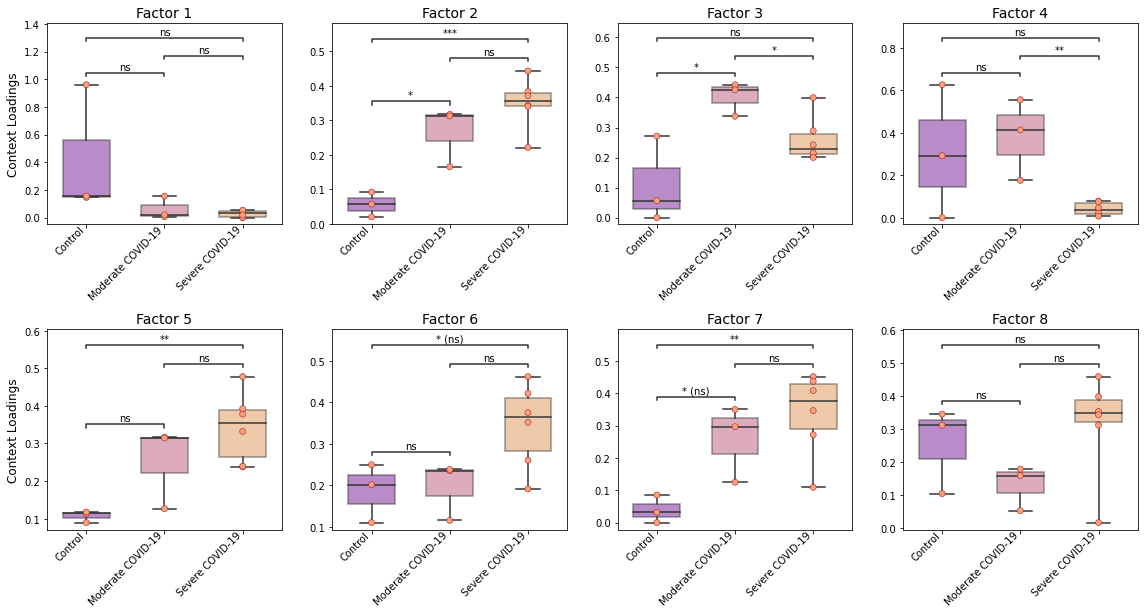

In [7]:
boxplot = c2c.plotting.factor_plot.context_boxplot(factors['Contexts'],
                                                   metadict=context_dict,
                                                   nrows=2,
                                                   figsize=(16, 9),
                                                   group_order=['Control', 'Moderate COVID-19', 'Severe COVID-19'],
                                                   statistical_test='t-test_ind',
                                                   pval_correction='benjamini-hochberg',
                                                   cmap='plasma',
                                                   verbose=False, # Use True to report test-statistics & P-values
                                                   filename=output_folder + '/BALF-Severity-Boxplots.pdf'
                                                  )

Here, we see that the communication patterns (or context loadings) identified statistically significant patterns when comparing each pair of COVID-19 severities.

These factors thus represent differences in the ligand-receptor interactions as well as cell types participating in cell-cell communication among the different COVID-19 severities.

### Correlation between Context Loadings & COVID-19 Severity

We first define the ranking of the severity, where higher values represent the worst severity.

In [8]:
def severity_rank(x):
    if x == 'Control':
        ranking = 1
    elif x == 'Moderate COVID-19':
        ranking = 2
    elif x == 'Severe COVID-19':
        ranking = 3
    return ranking

We generate a dataframe with the same indexes as the dataframe containing the loadings, then assign those rankings here.

In [9]:
sev_rank = pd.DataFrame(index=factors['Contexts'].index)
sev_rank['Severity-Ranking'] = [severity_rank(context_dict[idx]) for idx in factors['Contexts'].index]

Number of factors from the tensor decomposition

In [10]:
nfactors = factors['Contexts'].shape[1]

**Spearman correlation**

In [11]:
import scipy
for i in range(1, nfactors+1):
    factor = 'Factor {}'.format(i)
    print(factor, scipy.stats.spearmanr(factors['Contexts'][factor],
                                sev_rank['Severity-Ranking']))

Factor 1 SpearmanrResult(correlation=-0.6372694925323243, pvalue=0.02581849400578931)
Factor 2 SpearmanrResult(correlation=0.8534859274986488, pvalue=0.0004135604992741732)
Factor 3 SpearmanrResult(correlation=0.11379812366648649, pvalue=0.7247294545217076)
Factor 4 SpearmanrResult(correlation=-0.4665723070325946, pvalue=0.1262522308991266)
Factor 5 SpearmanrResult(correlation=0.7852070532987568, pvalue=0.0024785879051379663)
Factor 6 SpearmanrResult(correlation=0.6486493048989731, pvalue=0.022501714599676346)
Factor 7 SpearmanrResult(correlation=0.7169281790988649, pvalue=0.008690936968371105)
Factor 8 SpearmanrResult(correlation=0.37553380809940545, pvalue=0.22899397045329203)


### Heatmaps

**Cluster samples/contexts by their importance across factors**

Here we provide a example on how clustering samples colored by COVID-19 severity. If you plan adding colors for additional data and patient's properties. A detailed guide can be found here: https://www.chrisremmel.com/post/seaborn-color-labels/

Once having a dataframe or a dictionary for coloring patients/samples, the parameter ```col_colors``` should be changed. Make sure to use the same sample labels as in ```factors['Contexts'].index```

In [12]:
# Generate color by COVID-19 severity for each sample
condition_colors = c2c.plotting.aesthetics.get_colors_from_labels(['Control', 'Moderate COVID-19', 'Severe COVID-19'],
                                                                  cmap='plasma')

# Map these colors to each sample name
color_dict = {k : condition_colors[v] for k, v in context_dict.items()}

# Generate a dataframe used as input for the clustermap
col_colors = pd.Series(color_dict)
col_colors = col_colors.to_frame()
col_colors.columns = ['COVID-19 Severity']

How the color dataframe looks like. If you want to show multiple properties, add new columns with the names you want to display them, and the respective colors.

In [13]:
col_colors.head()

,COVID-19 Severity
HC1,"(0.050383, 0.029803, 0.527975, 1.0)"
HC2,"(0.050383, 0.029803, 0.527975, 1.0)"
HC3,"(0.050383, 0.029803, 0.527975, 1.0)"
M1,"(0.610667, 0.090204, 0.619951, 1.0)"
M2,"(0.610667, 0.090204, 0.619951, 1.0)"


Now generate the clustermap of samples given their respective loadings, colored by category of ASD condition.

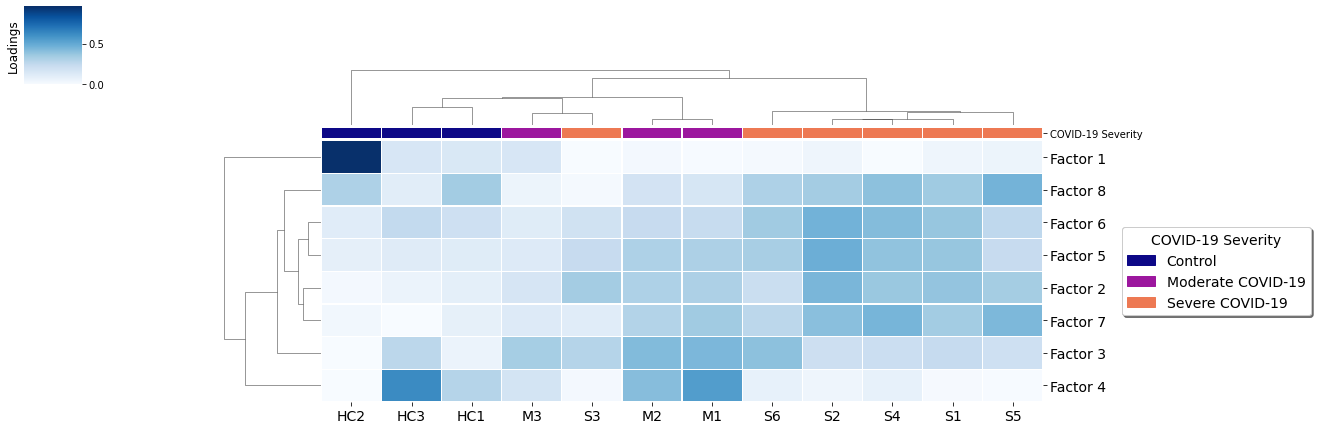

In [14]:
sample_cm = c2c.plotting.loading_clustermap(factors['Contexts'],
                                            use_zscore=False, # Whether standardizing the loadings across factors
                                            col_colors=col_colors, # Change this to color by other properties
                                            figsize=(16, 6),
                                            dendrogram_ratio=0.3,
                                            cbar_fontsize=12,
                                            tick_fontsize=14,
                                            filename=output_folder + 'Clustermap-Contexts.pdf'
                                           )

#Insert legend
plt.sca(sample_cm.ax_heatmap)
legend = c2c.plotting.aesthetics.generate_legend(color_dict=condition_colors,
                                                 bbox_to_anchor=(1.1, 0.5), # Position of the legend (X, Y)
                                                 title='COVID-19 Severity'
                                                )

Here patients are grouped by the importance that each the communication pattern (factor) has in relation to the others, within patient. Thus, a combination of communication patterns can explain differences at the sample-specific level. In this case the differences are reflected with an almost perfect clustering by COVID-19 severity, where moderate cases are more similar to control cases.

**Cluster LR pairs by their importance across factors**

To consider important LR pairs in at least one factor, set a loading_threshold. This value can be obtained in the way that user thinks is pertinent. Here we use ```loading_threshold=0.1```.

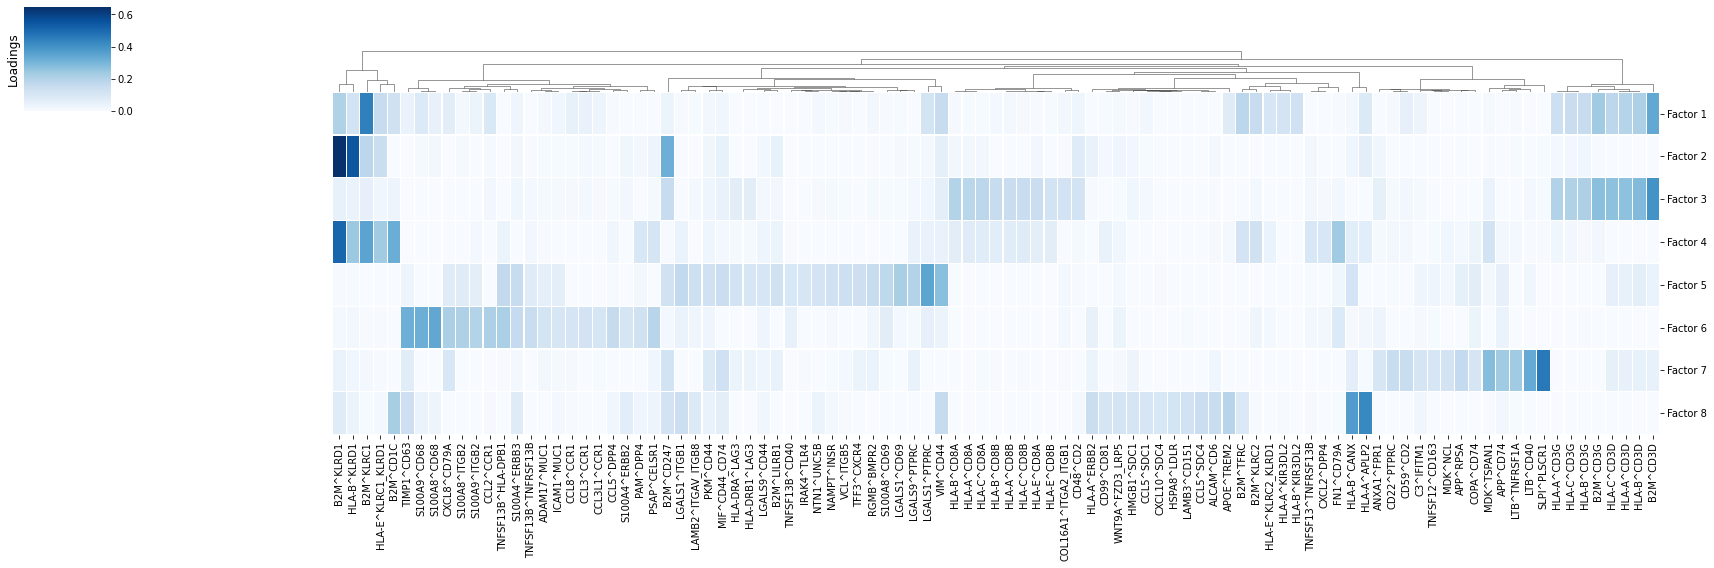

In [15]:
lr_cm = c2c.plotting.loading_clustermap(factors['Ligand-Receptor Pairs'],
                                        loading_threshold=0.1, # To consider only top LRs
                                        use_zscore=False, # Whether standardizing the loadings across factors
                                        figsize=(24, 8),
                                        filename=output_folder + 'Clustermap-LRs.pdf',
                                        row_cluster=False # To avoid clustering of factors
                                       )

In this case, LR pairs are grouped according to how differentially important they for one factor versus the others. This can give an idea of the molecular mechanisms that are crucial in each communication pattern.

**Cluster sender-receiver pairs for an specific factor**

Factor 6 has a decent correlation with COVID-19 Severity, and all Severe cases presented higher loadings than the rest. Thus, this factor seems an interesting pattern to analyze. To do so, we define its Loading Product between senders and receiver cells, which represents the joint importance of the cell-cell pair:

In [16]:
loading_product = c2c.analysis.tensor_downstream.get_joint_loadings(factors,
                                                                    dim1='Sender Cells',
                                                                    dim2='Receiver Cells',
                                                                    factor='Factor 6'
                                                                   )

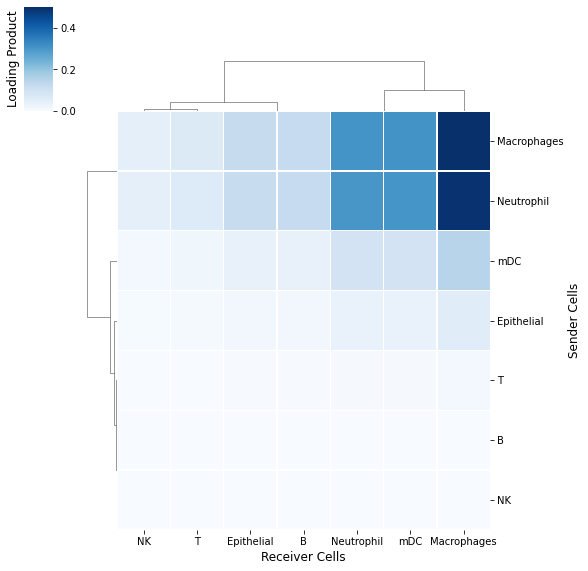

In [17]:
lprod_cm = c2c.plotting.loading_clustermap(loading_product.T, # Remove .T to transpose the axes
                                           use_zscore=False, # Whether standardizing the loadings across factors
                                           figsize=(8, 8),
                                           filename=output_folder + 'Clustermap-CC-Pairs.pdf',
                                           cbar_label='Loading Product',
                                          )

Here, communication FROM macrophages & neutrophils TO macrophages, neutrophils & mDC is the most important, and is correlated with COVID-19 Severity. From the LR loadings mechanisms such as the interactions of S100A-CD68 and TIMP1-CD63 are important, consistent with previously reported results where these LR pairs are associated with poor prognosis of COVID-19 and more severe cases: 
- https://www.sciencedirect.com/science/article/pii/S0092867420309934?via%3Dihub
- https://www.cell.com/trends/cell-biology/fulltext/S0962-8924(22)00207-0

### Gini coefficients of the factor-specific cell-cell communication

Gini coefficient quantifies how different are the sender-receiver cell pairs in each factor given their importances. Here it is use to measure the imbalance of communication. In other words, to identify whether few cells are key for the pattern found, or the pattern corresponds to a more general process that involves most of the cell types.

Higher Gini coefficients are for communication where few cell types are important. Lower values represent more general processes of communication involving most of the cell types. Gini coefficients can be any value between [0, 1]

In [18]:
c2c.analysis.tensor_downstream.compute_gini_coefficients(factors,
                                                         sender_label='Sender Cells',
                                                         receiver_label='Receiver Cells'
                                                        )

,Factor,Gini
0,Factor 1,0.513565
1,Factor 2,0.696112
2,Factor 3,0.734752
3,Factor 4,0.598894
4,Factor 5,0.473199
5,Factor 6,0.729955
6,Factor 7,0.763965
7,Factor 8,0.549386


We observe that the lowest Gini coefficient was obtained by factor 5, which seems to have more balanced cell loadings. Senders and/or receivers are more similar or homogeneous.